In [1]:
from heapq import _siftup, _siftdown, heapify, nlargest

class Heap(list):
  def __init__(self, values, sort_fix=False, heap_fix=False, **kwargs):
    super().__init__(values)
    heapify(self)
    self._broken = False
    self.sort_fix = sort_fix
    self.heap_fix = heap_fix or not sort_fix

  # Solution 1) repair using the knowledge we have after every update:        
  def update(self, key, value):
    old, self[key] = self[key], value
    if value > old:
        _siftup(self, key)
    else:
        _siftdown(self, 0, key)
    
  # Solution 2 and 3) repair using sort/heapify in a lazzy way:
  def __setitem__(self, key, value):
    super().__setitem__(key, value)
    self._broken = True
    
  def __getitem__(self, key):
    if self._broken:
        self._repair()
        self._broken = False
    return super().__getitem__(key)

  def _repair(self):  
    if self.sort_fix:
        self.sort()
    elif self.heap_fix:
        heapify(self)

  # … you'll also need to delegate all other heap functions, for example:
  def nlargest(self, n):
    self._repair()
    return nlargest(n, self)

In [2]:
data = [10, 5, 18, 2, 37, 3, 8, 7, 19, 1]

heap = Heap(data[:])
heap.update(8, 22)
heap.update(7, 4)
print(heap.nlargest(len(data)))

heap = Heap(data[:], sort_fix=True)
heap[8] = 22
heap[7] = 4
print(heap.nlargest(len(data)))

heap = Heap(data[:], heap_fix=True)
heap[8] = 22
heap[7] = 4
print(heap.nlargest(len(data)))

[37, 22, 18, 8, 7, 5, 4, 3, 2, 1]
[37, 22, 18, 8, 7, 5, 4, 3, 2, 1]
[37, 22, 18, 8, 7, 5, 4, 3, 2, 1]


In [3]:
import time
import random

def rand_update(heap, lazzy_fix=False, **kwargs):
    index = random.randint(0, len(heap)-1)
    new_value = random.randint(max_int+1, max_int*2)
    if lazzy_fix:
        heap[index] = new_value
    else:
        heap.update(index, new_value)
    
def rand_updates(n, heap, lazzy_fix=False, **kwargs):
    for _ in range(n):
        rand_update(heap, lazzy_fix)
        
def run_perf_test(n, data, **kwargs):
    test_heap = Heap(data[:], **kwargs)
    t0 = time.time()
    rand_updates(n, test_heap, **kwargs)
    test_heap[0]
    return (time.time() - t0)*1e3

In [4]:
test_size = int(1e5)
max_int = 100
test_data = [random.randint(0, max_int) for _ in range(test_size)]
nb_updates = 1

perf = run_perf_test(nb_updates, test_data)
print(f"update (sift): {perf}ms")
perf = run_perf_test(nb_updates, test_data, lazzy_fix=True, heap_fix=True)
print(f"attack (heapify reparation): {perf}ms")
perf = run_perf_test(nb_updates, test_data, lazzy_fix=True, sort_fix=True)
print(f"attack (sort reparation): {perf}ms")

update (sift): 12.902975082397461ms
attack (heapify reparation): 4.664897918701172ms
attack (sort reparation): 9.505987167358398ms


In [5]:
results = []
max_int = 500
nb_updates = 1

for i in range(3, 7):
    test_size = 10**i
    test_data = [random.randint(0, max_int) for _ in range(test_size)]

    perf = run_perf_test(nb_updates, test_data)
    results.append((test_size, "update", perf))
    
    perf = run_perf_test(nb_updates, test_data, lazzy_fix=True, heap_fix=True)
    results.append((test_size, "heapify", perf))

    perf = run_perf_test(nb_updates, test_data, lazzy_fix=True, sort_fix=True)
    results.append((test_size, "sort", perf))

    heap size   method  duration in ms
0        1000   update        0.435114
1        1000  heapify        0.073195
2        1000     sort        0.101089
3       10000   update        1.668930
4       10000  heapify        0.480175
5       10000     sort        1.151085
6      100000   update       13.194084
7      100000  heapify        4.875898
8      100000     sort       11.922121
9     1000000   update      153.587103
10    1000000  heapify       51.237106
11    1000000     sort      145.306110


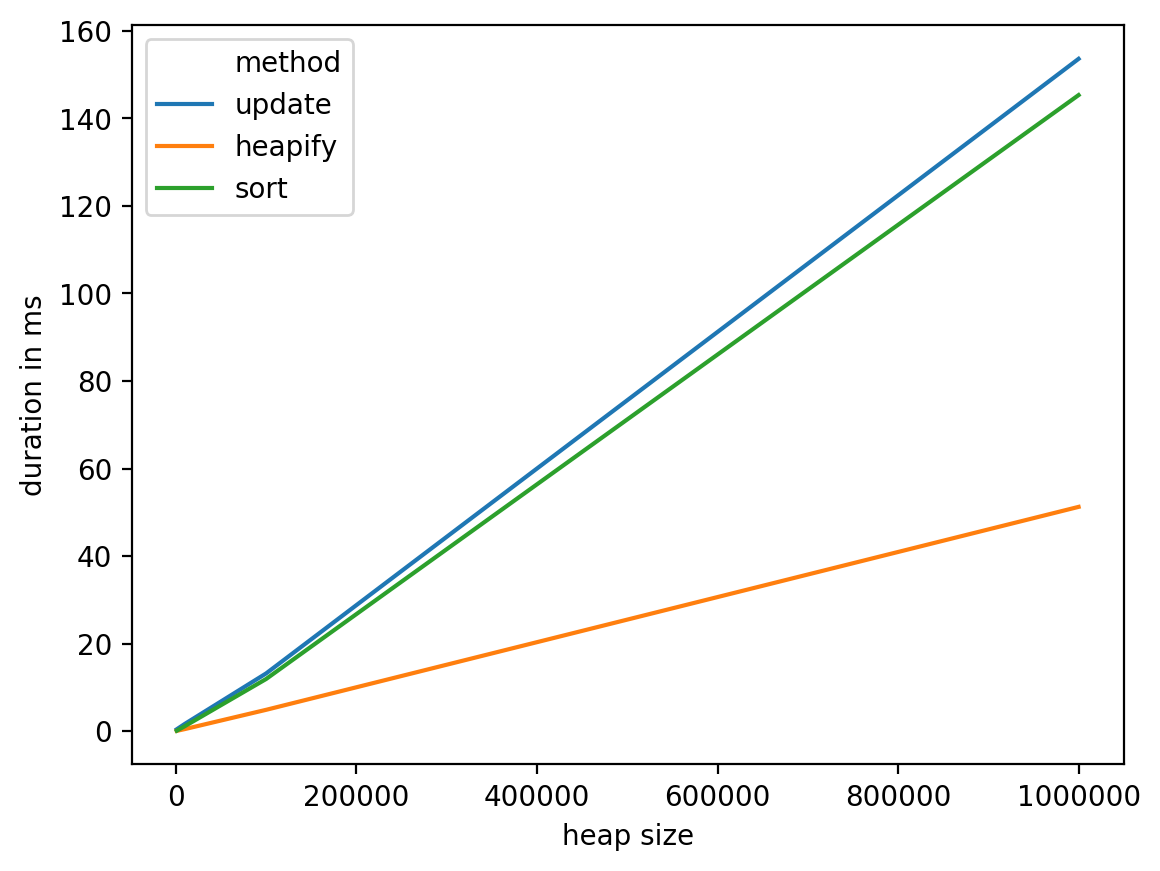

In [9]:
%matplotlib inline
import pandas as pd
import seaborn as sns

dtf = pd.DataFrame(results, columns=["heap size", "method", "duration in ms"])
print(dtf)

sns.reset_orig()
sns.lineplot(
    data=dtf, 
    x="heap size", 
    y="duration in ms", 
    hue="method",
)